<a href="https://colab.research.google.com/github/dlgallegose/AI-Seminar/blob/main/AI-Seminar-Data-To-Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Seminar: Data to Decisions: ML SOLUTIONS FOR WATER CHALLENGES IN THE BORDERLAND

**Author:** Damian L. Gallegos <br>
Computer Science Department<br>
University of Texas at El Paso<br>
**Last modified:** 7/16/2023<br>

**Data Exploration and Discussion**

We will clean and use climate data from a Google Earth Engine (GEE) to predict evapotranspiration (ET).  For each technique, the input and output are as follows:

**Input**: A raster image with a pixel resolution of 1000 meters.

**Output**: Models that use some features to predict the target ET.

We also estimate how well each model performs.

## Installations



In [1]:
!pip install contextily

In [2]:
!pip install cartopy

#Libraries


These are the collection of pre-written code that can be imported and use for your own python programs. With out the need to re-writted yourself.

In [82]:
import ee
import json
import shap
import time
import joblib
import numpy as np
import pandas as pd
import contextily as cx
import cartopy.crs as ccrs
from sklearn import metrics
import geemap.core as geemap
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap

#Authentification

To access Google Earth Engine (GEE) data, you must create a project using your Google credentials in the [Google Earth Engine Code Editor](https://code.earthengine.google.com/).

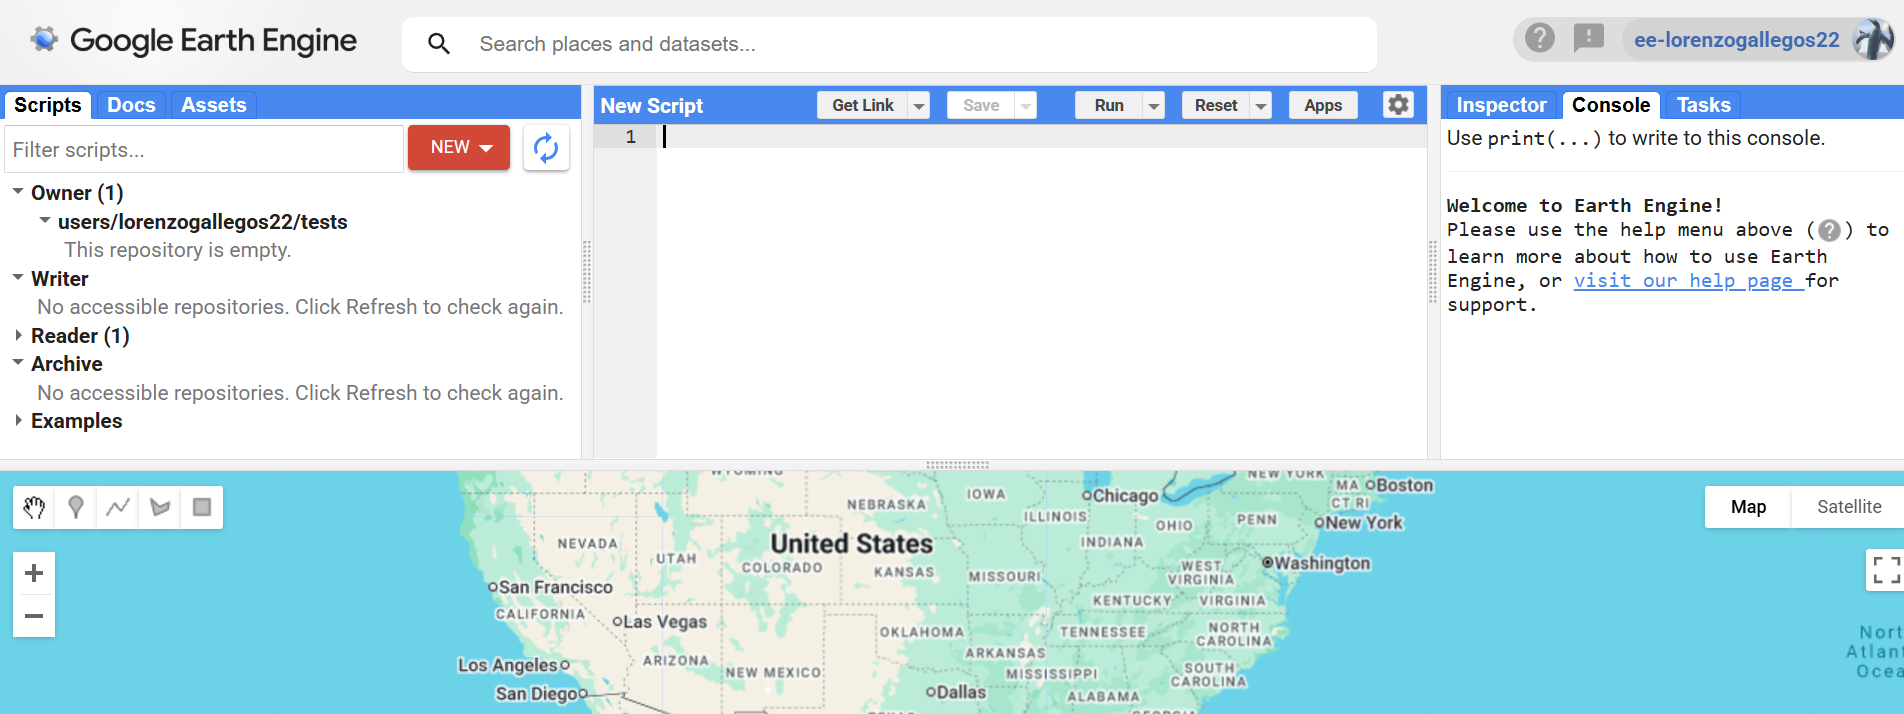

In the upper right corner, the name of your project will appear. Then you will insert the name of your project below to authenticate.

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-lorenzogallegos22') #Type the name of your project, the will generally begin with "ee-name_of_your_project".

Once you authenticate, you will have access to all the remote sensing data from NASA and other agencies compiled in the GEE tool.

#Loading Data and Licensing

To load the raster image, we need to use the "ee" library and the name of the dataset. You can find multiple different datasets here [GEE Datasets](https://developers.google.com/earth-engine/datasets).

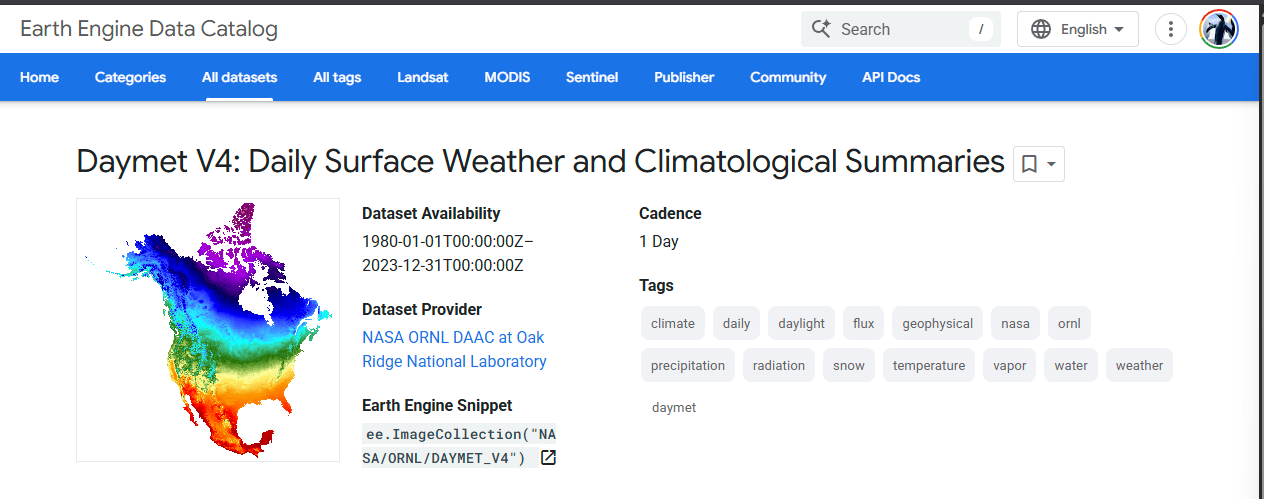

To find the name of the dataset, copy and paste the text inside the parentheses under **"Earth Engine Snippet"**. The following code line will call the dataset and load it.

##Licensing

The terms of use of any dataset are of vital importance. This will indicate whether we can use a dataset and, if so, how. For our particular case, the terms of use indicate public domain and availability without restriction on use and distribution. In addition, it is good practice to cite the papers related to this dataset.

In [5]:
Data = ee.ImageCollection("NASA/ORNL/DAYMET_V4")

Raster images have different bands. These bands are values that depend on the electromagnetic spectrum captured by the sensors. Another way to explain it is as a matrix representing a geographical location with a certain resolution (i.e., 30 x 30 meters), allowing for a raster image of 1080x1080 pixels. This means there are 1080^2 pixels, each measuring 30^2 meters. Also, these pixels could store more than one value depending on the number of bands/layers. More information could be found at the ArcGIS software webpage [Raster Bands](https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/raster-bands-pro-.htm).

In this case, there are seven bands as described on the following image. To access a band, we need to select it and a date range.

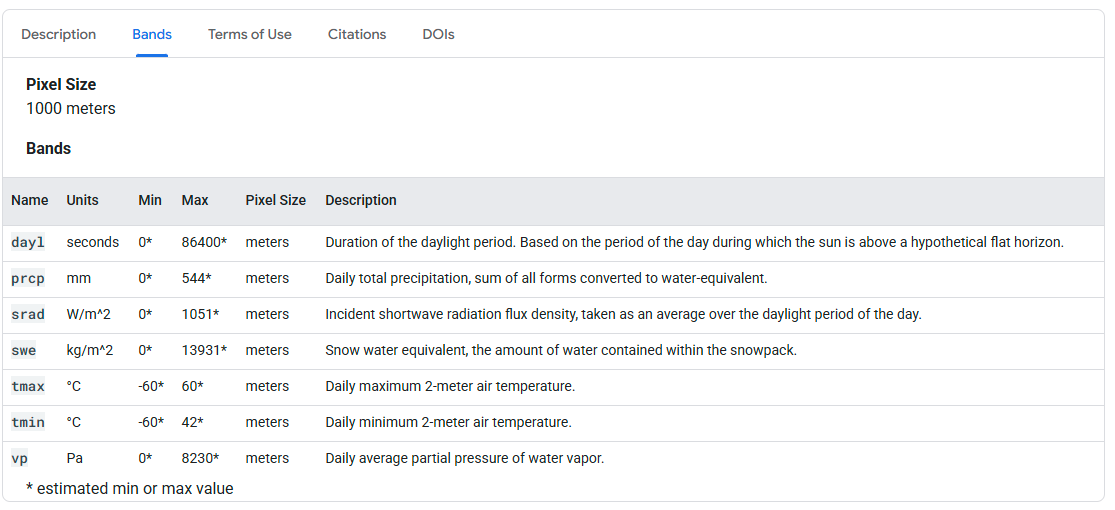

#Data Extraction

To extract information from the dataset, we must specify both the bands and the initial and final dates of interest. In our case, we aim to predict radiation using daylight, precipitation, maximum temperature, minimum temperature, and partial pressure of water vapor as features. We will exclude the snow water equivalent, since our area of interest, El Paso, Texas, only has snow on extraordinary occasions.

In [6]:
# Initial date of interest.
i_date = '1980-01-01'

# Final date of interest.
f_date = '2023-12-31'

# Selection of appropriate bands and dates.
Data = Data.select('dayl', 'prcp', 'srad','tmax', 'tmin', 'vp').filterDate(i_date, f_date)

We can select a point of interest.

In [7]:
# Define the urban location of interest as a point.
longitude  = -106.485022
latitude = 31.761878
u_poi = ee.Geometry.Point(longitude, latitude)

We can also plot the point of interst.

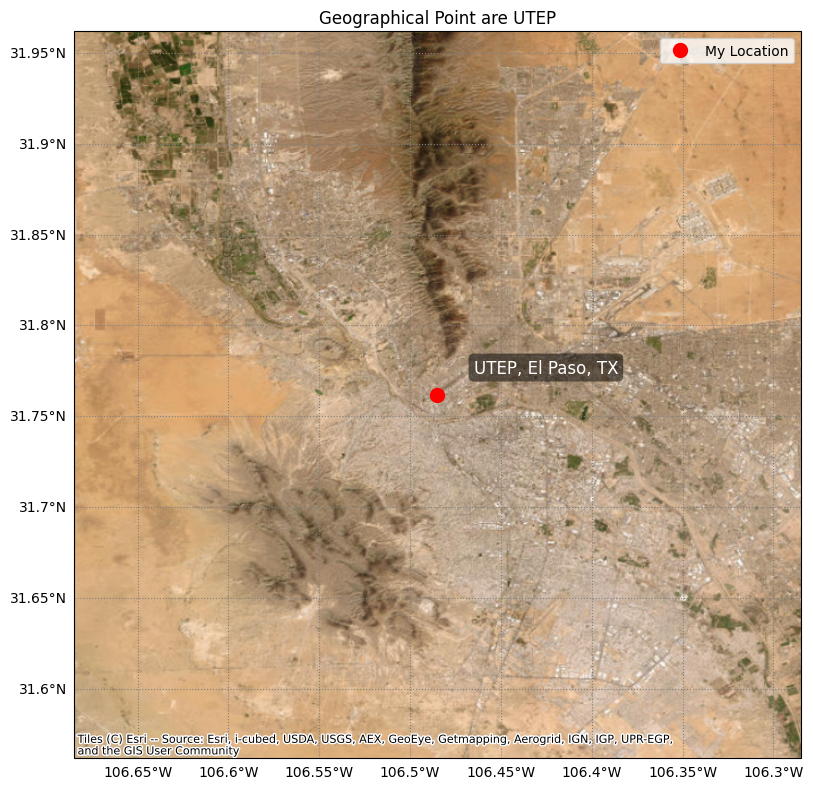

In [8]:
# We use PlateCarree projection here, which directly maps lat/lon
# contextily can reproject the basemap to match this.
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# This should be in the same CRS as your axes (PlateCarree in this case)
# Adjust these values to zoom in or out around your point
ax.set_extent([longitude - 0.2, longitude + 0.2, latitude - 0.2, latitude + 0.2], crs=ccrs.PlateCarree())

# Crucially, specify the 'transform' for the point. It's in PlateCarree (Lat/Lon).
ax.plot(longitude, latitude, 'o', color='red', markersize=10, transform=ccrs.PlateCarree(), label='My Location')

# cx.add_basemap automatically reprojects the tiles to the axes' projection.
# The `crs` argument helps contextily understand your plot's CRS.
# Use zorder to ensure the point is on top of the basemap.
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery, zorder=0)

# Add a text label next to the point
ax.text(longitude + 0.02, latitude + 0.01, 'UTEP, El Paso, TX', transform=ccrs.PlateCarree(),
        fontsize=12, color='white', ha='left', va='bottom',
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

# Add labels and title
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("Geographical Point are UTEP")

# Add gridlines (optional, but good for geographical context)
gl = ax.gridlines(draw_labels=True, linestyle=':', alpha=1, color='gray')
gl.top_labels = False    # Hide labels on top
gl.right_labels = False  # Hide labels on right

ax.legend()
plt.tight_layout()

plt.show()

Once we defined our point of interest, we can extract the values of the location for a specific date.

In [9]:
#Define the scale of the dataset.
scale = 1000

# Select an image for a specific day
date_to_extract = '2023-07-15'
day_image = Data.filterDate(date_to_extract).first()

We are able to print the values for all bands for the specific date.

In [10]:
# Select an image for a specific day
date_to_extract = '2023-07-15'
day_image = Data.filterDate(date_to_extract).first()

# Reduce the image to get values at the urban point
point_data_dict_ee = day_image.reduceRegion(reducer=ee.Reducer.first(), geometry=u_poi, scale=scale, maxPixels=1e9)

point_data_dict = point_data_dict_ee.getInfo()

# You can iterate through all values too:
print("\nAll band values extracted:")
for band_name, band_value in point_data_dict.items():
    print(f"- {band_name}: {band_value}")


All band values extracted:
- dayl: 49982.51171875
- prcp: 0
- srad: 380.8699951171875
- tmax: 38.72999954223633
- tmin: 26.25
- vp: 1336.8599853515625


#Data Frame Creation

In [11]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [12]:
# Define the scale of the dataset.
scale = 1000 #meters

# Extract data for the urban point over the specified date range
# The getRegion method returns an array of data
data_array_ee = Data.getRegion(
    geometry=u_poi,
    scale=scale,
    crs='EPSG:4326' # Specify a CRS / system of coordinates
)

# Use .getInfo() to bring the results to the client-side
data_array = data_array_ee.getInfo()

# List of bands to extract (used by ee_array_to_df)
bands_to_extract = ['dayl', 'prcp', 'srad','tmax', 'tmin', 'vp']

# Convert the extracted data array to a pandas DataFrame
Data_df_urban = ee_array_to_df(data_array, bands_to_extract)

# Display the first few rows of the DataFrame
display(Data_df_urban.head())

# Display information about the DataFrame
print("\nDataFrame Info:")
Data_df_urban.info()

,time,datetime,dayl,prcp,srad,tmax,tmin,vp
0,315532800000,1980-01-01,35881.488281,0.0,331.350006,14.98,-4.57,242.059998
1,315619200000,1980-01-02,35910.960938,0.0,318.089996,15.85,-2.16,294.029999
2,315705600000,1980-01-03,35942.839844,0.0,299.239990,13.19,-2.87,308.179993
3,315792000000,1980-01-04,35977.121094,0.0,335.000000,15.29,-4.37,240.990005
4,315878400000,1980-01-05,36013.781250,0.0,347.350006,16.52,-4.77,220.339996



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16059 entries, 0 to 16058
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   time      16059 non-null  object        
 1   datetime  16059 non-null  datetime64[ns]
 2   dayl      16059 non-null  float64       
 3   prcp      16059 non-null  float64       
 4   srad      16059 non-null  float64       
 5   tmax      16059 non-null  float64       
 6   tmin      16059 non-null  float64       
 7   vp        16059 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1003.8+ KB


#Dataset Modifications

It is a good practice to make a copy of the generated dataframes, so you can always go back if your dataset gets ruined.

In [13]:
Data_df = Data_df_urban.copy()

Remove the "time" feature, as it is unnecessary.

In [14]:
Data_df['dayl (HR)'] = Data_df['dayl'] / 3600

We need the following line to determine the specific day number throughout the year. For example, January 1st is equivalent to 1.

In [15]:
Data_df['Day of Year'] = Data_df['datetime'].dt.dayofyear.astype(int)

Now we can drop the columns/features that are not going to be used.

In [16]:
Data_df.drop(columns=['time', 'dayl', 'datetime'], inplace=True)

Let's separete our target from our dataframe.

In [17]:
radiation = Data_df['srad']
Data_df.drop(columns=['srad'], inplace=True)

Features

In [18]:
Data_df.head()

,prcp,tmax,tmin,vp,dayl (HR),Day of Year
0,0.0,14.98,-4.57,242.059998,9.967080,1
1,0.0,15.85,-2.16,294.029999,9.975267,2
2,0.0,13.19,-2.87,308.179993,9.984122,3
3,0.0,15.29,-4.37,240.990005,9.993645,4
4,0.0,16.52,-4.77,220.339996,10.003828,5


Target

In [19]:
radiation.head()

,srad
0,331.350006
1,318.089996
2,299.239990
3,335.000000
4,347.350006


#Train, testing split

We are going to split the data on a 80/20 proportion. This way 12847 datapoints are used for training and 3212 dapoints for testing.

In [20]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Data_df, radiation, test_size=0.2)

#Regression Task Models.

Once we have our dataframe, we can train and create machine learning models. For now, we will implement an ML model using decision trees.

Target Feature:

*  Solar Radiation (srad) 16059 datapoints.

Training Features: 16059 datapoints per feature.


*  Precipitation
* Maximum Temperature
*  Minimum Temperature
*  Water Vapor Pressure
*  Sunlight
*  Day of Year


##Random Forest Regressor (RFR)

### Training and Prediction

In [21]:
model_RFR = RandomForestRegressor(n_estimators = 100)
model_RFR.fit(X_train, Y_train)

RandomForestRegressor()

In [22]:
predictions_RFR = model_RFR.predict(X_test)

In [23]:
# Model evaluation
MSE_RFR = metrics.mean_squared_error(Y_test, predictions_RFR)
RMSE_RFR = np.sqrt(MSE_RFR)
MAE_RFR = metrics.mean_absolute_error(Y_test, predictions_RFR)
MAPE_RFR = metrics.mean_absolute_percentage_error(Y_test, predictions_RFR)
R2_RFR = metrics.r2_score(Y_test, predictions_RFR)

print(f'Mean Squared Error (MSE): {MSE_RFR:.4}')
print(f'Root Mean Squared Error (RMSE): {RMSE_RFR:.4}')
print(f'Mean Absolute Error (MAE): {MAE_RFR:.4}')
print(f'Mean Absolute Percentage Error (MAPE): {MAPE_RFR:.4}')
print(f'R-score: {R2_RFR}')

Mean Squared Error (MSE): 316.8
Root Mean Squared Error (RMSE): 17.8
Mean Absolute Error (MAE): 13.34
Mean Absolute Percentage Error (MAPE): 0.03825
R-score: 0.9683751811708543


### SHAP Analysis RFR

Explainer creation and SHAP values for the first 1000 datapoints

In [24]:
explainer = shap.TreeExplainer(model_RFR)
#shap_values = explainer(X_test) this will process all datapoints
shap_values = explainer(X_test[:1000]) # First 1000 data points
shap.initjs()

####Plot of the SHAP values

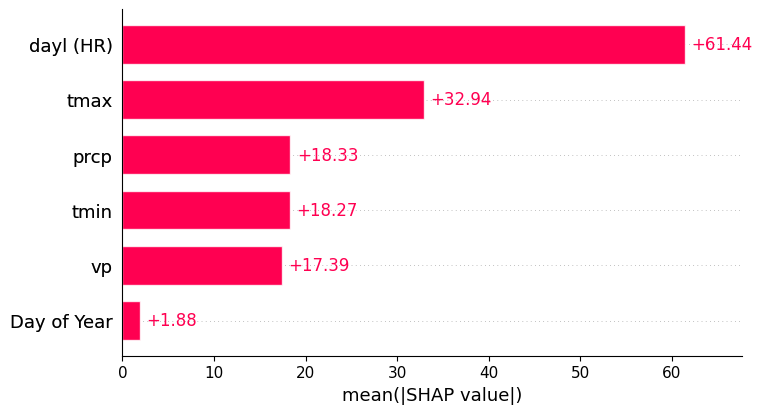

In [25]:
shap.plots.bar(shap_values)

####Beeswarm plot

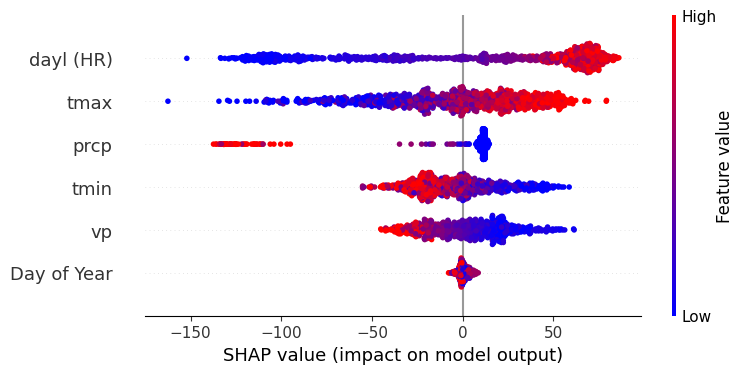

In [30]:
colors = ['Blue', 'Red']
custom_cmap = LinearSegmentedColormap.from_list("blue_orange", colors)
shap.plots.beeswarm(shap_values, color=plt.get_cmap(custom_cmap))

### Scatter Plot

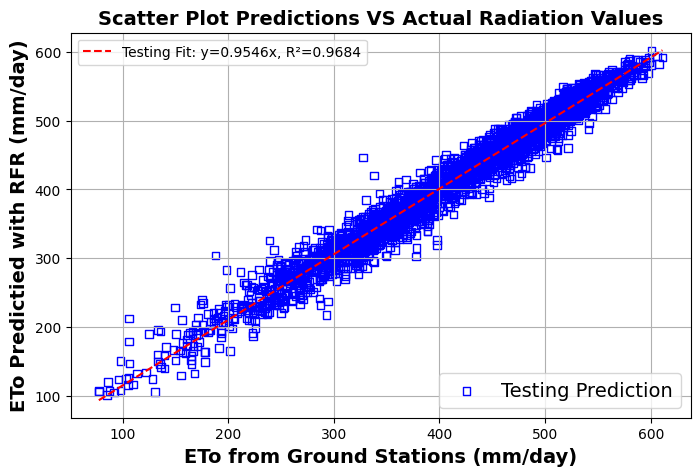

In [31]:
#Lines
m_test, b_test = np.polyfit(Y_test, predictions_RFR, 1)
# Min max Definition
x_fit_test = np.linspace(min(Y_test), max(Y_test), 100)
# Testing fit
y_fit_test = m_test * x_fit_test + b_test

# Plotting
plt.figure(figsize=(8, 5))
scatter_test = plt.scatter(Y_test, predictions_RFR, marker='s', s=30, label='Testing Prediction', edgecolors='Blue', facecolors='none', linewidths=1)

# Regression lines
line_test, = plt.plot(x_fit_test, y_fit_test, color='Red', label=f'Testing Fit: y=%0.4fx, R²=%0.4f' % (m_test, R2_RFR), linestyle='--')

#Titles
plt.xlabel('ETo from Ground Stations (mm/day)',fontsize = 14, weight = 'bold')
plt.ylabel('ETo Predictied with RFR (mm/day)', fontsize =14, weight = 'bold')
plt.title('Scatter Plot Predictions VS Actual Radiation Values RFR Model', fontsize =14, weight = 'bold')
plt.grid(True)

# First legend for scatter points
legend1 = plt.legend(handles=[scatter_test], loc='lower right', fontsize =14)

# Adding the first legend to the plot
plt.gca().add_artist(legend1)

# Second legend for fitted lines
plt.legend(handles=[line_test], loc='upper left')
plt.show()


##Multilayer Perception Model

Function that defined the strecture of the MLP model

In [74]:
def build_model_using_sequential():
  model_MLP = Sequential([

    Dense(120, kernel_initializer='normal', kernel_regularizer=l2(0.0001), activation='relu'),
    Dropout(0.3),

    Dense(56, kernel_initializer='uniform',kernel_regularizer=l2(0.0001), activation='tanh'),
    Dropout(0.2),

    Dense(30, kernel_initializer='normal', kernel_regularizer=l2(0.0001),activation='relu'),
    Dropout(0.2),

    Dense(16, kernel_initializer='normal', kernel_regularizer=l2(0.001), activation='relu'),
    Dropout(0.2),

    Dense(1, kernel_initializer='normal', activation='relu')]
  )
  return model_MLP
model_MLP = build_model_using_sequential()

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

### Training

In [77]:
model_MLP.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['MSE']
)
# train the model
history = model_MLP.fit(
    X_train.values,
    Y_train.values,
    epochs=150,
    callbacks = [early_stopping],
    verbose=1,
    batch_size=256,
    validation_split=0.2,
)

predictions_MLP = model_MLP.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(Y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(Y_test, y_pred)
R = metrics.r2_score(Y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R2-score: {R}')

Epoch 1/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - MSE: 8037.6851 - loss: 8037.7368 - val_MSE: 1078.9487 - val_loss: 1078.9994
Epoch 2/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MSE: 7712.4443 - loss: 7712.4951 - val_MSE: 1305.5168 - val_loss: 1305.5669
Epoch 3/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MSE: 7601.0356 - loss: 7601.0859 - val_MSE: 1158.7560 - val_loss: 1158.8066
Epoch 4/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MSE: 7559.5425 - loss: 7559.5942 - val_MSE: 1054.7754 - val_loss: 1054.8257
Epoch 5/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - MSE: 7792.0889 - loss: 7792.1387 - val_MSE: 1042.7640 - val_loss: 1042.8148
Epoch 6/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - MSE: 7624.1489 - loss: 7624.1997 - val_MSE: 1018.8416 - val_loss: 1018.8922
Epoch 7/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - MSE: 7777.7617 - loss: 7777.8115 - val_MSE: 1469.3571 - val_loss: 1469.4076
Epoch 8/150
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - MSE: 7863.2397 - loss: 7863.2910 - val_MS

### Sacatter Plot

/tmp/ipython-input-3987387754.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  line_test, = plt.plot(x_fit_test, y_fit_test, color='Red', label=f'Testing Fit: y=%0.4fx, R²=%0.4f' % (m_test, R2_RFR), linestyle='--')


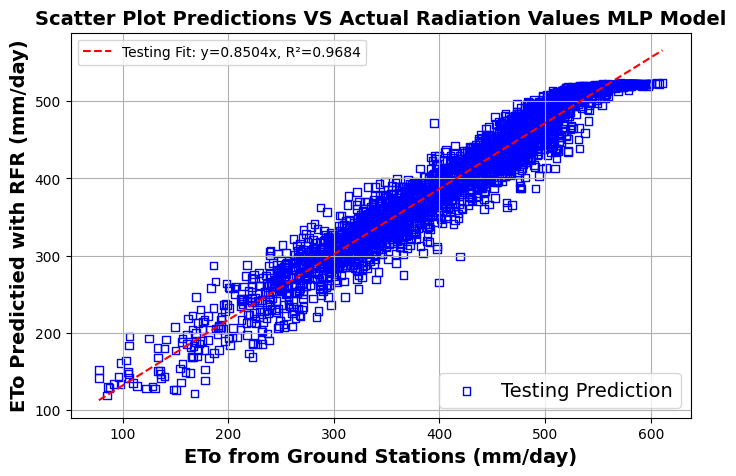

In [78]:
#Lines
m_test, b_test = np.polyfit(Y_test, predictions_MLP, 1)
# Min max Definition
x_fit_test = np.linspace(min(Y_test), max(Y_test), 100)
# Testing fit
y_fit_test = m_test * x_fit_test + b_test

# Plotting
plt.figure(figsize=(8, 5))
scatter_test = plt.scatter(Y_test, predictions_MLP, marker='s', s=30, label='Testing Prediction', edgecolors='Blue', facecolors='none', linewidths=1)

# Regression lines
line_test, = plt.plot(x_fit_test, y_fit_test, color='Red', label=f'Testing Fit: y=%0.4fx, R²=%0.4f' % (m_test, R2_RFR), linestyle='--')

#Titles
plt.xlabel('ETo from Ground Stations (mm/day)',fontsize = 14, weight = 'bold')
plt.ylabel('ETo Predictied with RFR (mm/day)', fontsize =14, weight = 'bold')
plt.title('Scatter Plot Predictions VS Actual Radiation Values MLP Model', fontsize =14, weight = 'bold')
plt.grid(True)

# First legend for scatter points
legend1 = plt.legend(handles=[scatter_test], loc='lower right', fontsize =14)

# Adding the first legend to the plot
plt.gca().add_artist(legend1)

# Second legend for fitted lines
plt.legend(handles=[line_test], loc='upper left')
plt.show()


### SHAP Analysis MLP

In [80]:
explainer = shap.Explainer(model_MLP, masker=shap.maskers.Independent(X_train.values))
# shap_values = explainer(X_test.values) all test data
shap_values = explainer(X_test[:1000])  # only first 1000
shap.initjs()

ExactExplainer explainer: 1001it [00:45, 21.00it/s]                         


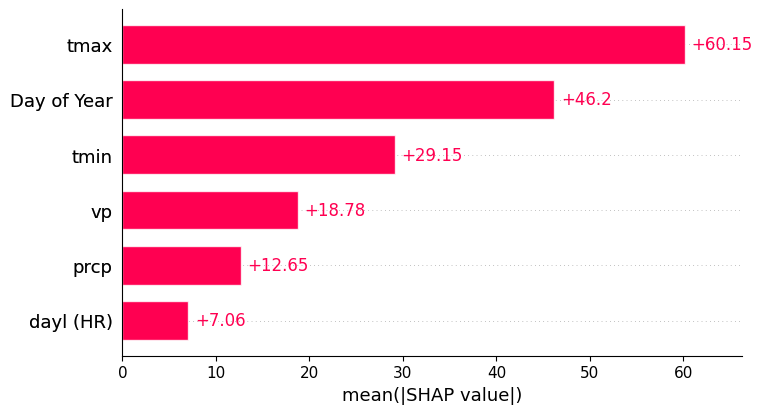

In [81]:
shap.plots.bar(shap_values)

#References

[1] M. M. Thornton, R. Shrestha, Y. Wei, P. E. Thornton, and S.-C. Kao, “Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4,” ORNL DAAC, Dec. 2020, doi: 10.3334/ORNLDAAC/1840. <br><br>
[2] M. M. Thornton, R. Shrestha, Y. Wei, P. E. Thornton, and S.-C. Kao, “Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4 R1,” ORNL DAAC, Nov. 2022, doi: 10.3334/ORNLDAAC/2129.
